# **TRAINING MODEL**

## **LOADING DATA**

In [1]:
# Import dataset

file_score = "../DATAS/CleanALL_EHCVM_ML.csv"

## **IMPORTS LIBRARIES**

In [2]:
# Imports Libairies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import joblib

import warnings

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, LabelBinarizer, label_binarize
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold

from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, r2_score, mean_squared_error, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV 


In [3]:
# Import Modèles

from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import xgboost as xgb
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')

## **READ DATA**

In [4]:
df_score = pd.read_csv(file_score)
C_df_score = df_score.copy()
C_df_score

,mstat,rev_total_mois,age_grp,empl_formel,bancarise,a_assurance,logem
0,Célibataire,279244.0,25-34,1,1,0,Locataire
1,Célibataire,0.0,0-17,0,0,0,Locataire
2,Célibataire,0.0,0-17,0,0,0,Locataire
3,Célibataire,0.0,0-17,0,0,0,Locataire
4,Marié(e),0.0,25-34,0,0,0,Locataire
...,...,...,...,...,...,...,...
64469,Célibataire,0.0,0-17,0,0,0,Proprietaire titre
64470,Célibataire,0.0,0-17,0,0,0,Proprietaire titre
64471,Célibataire,0.0,0-17,0,0,0,Proprietaire titre
64472,Célibataire,0.0,0-17,0,0,0,Proprietaire titre


## **COURBE KDE (Kernel Density Estimator) : Approximation of the probability density of each variable**

Differentes catégories


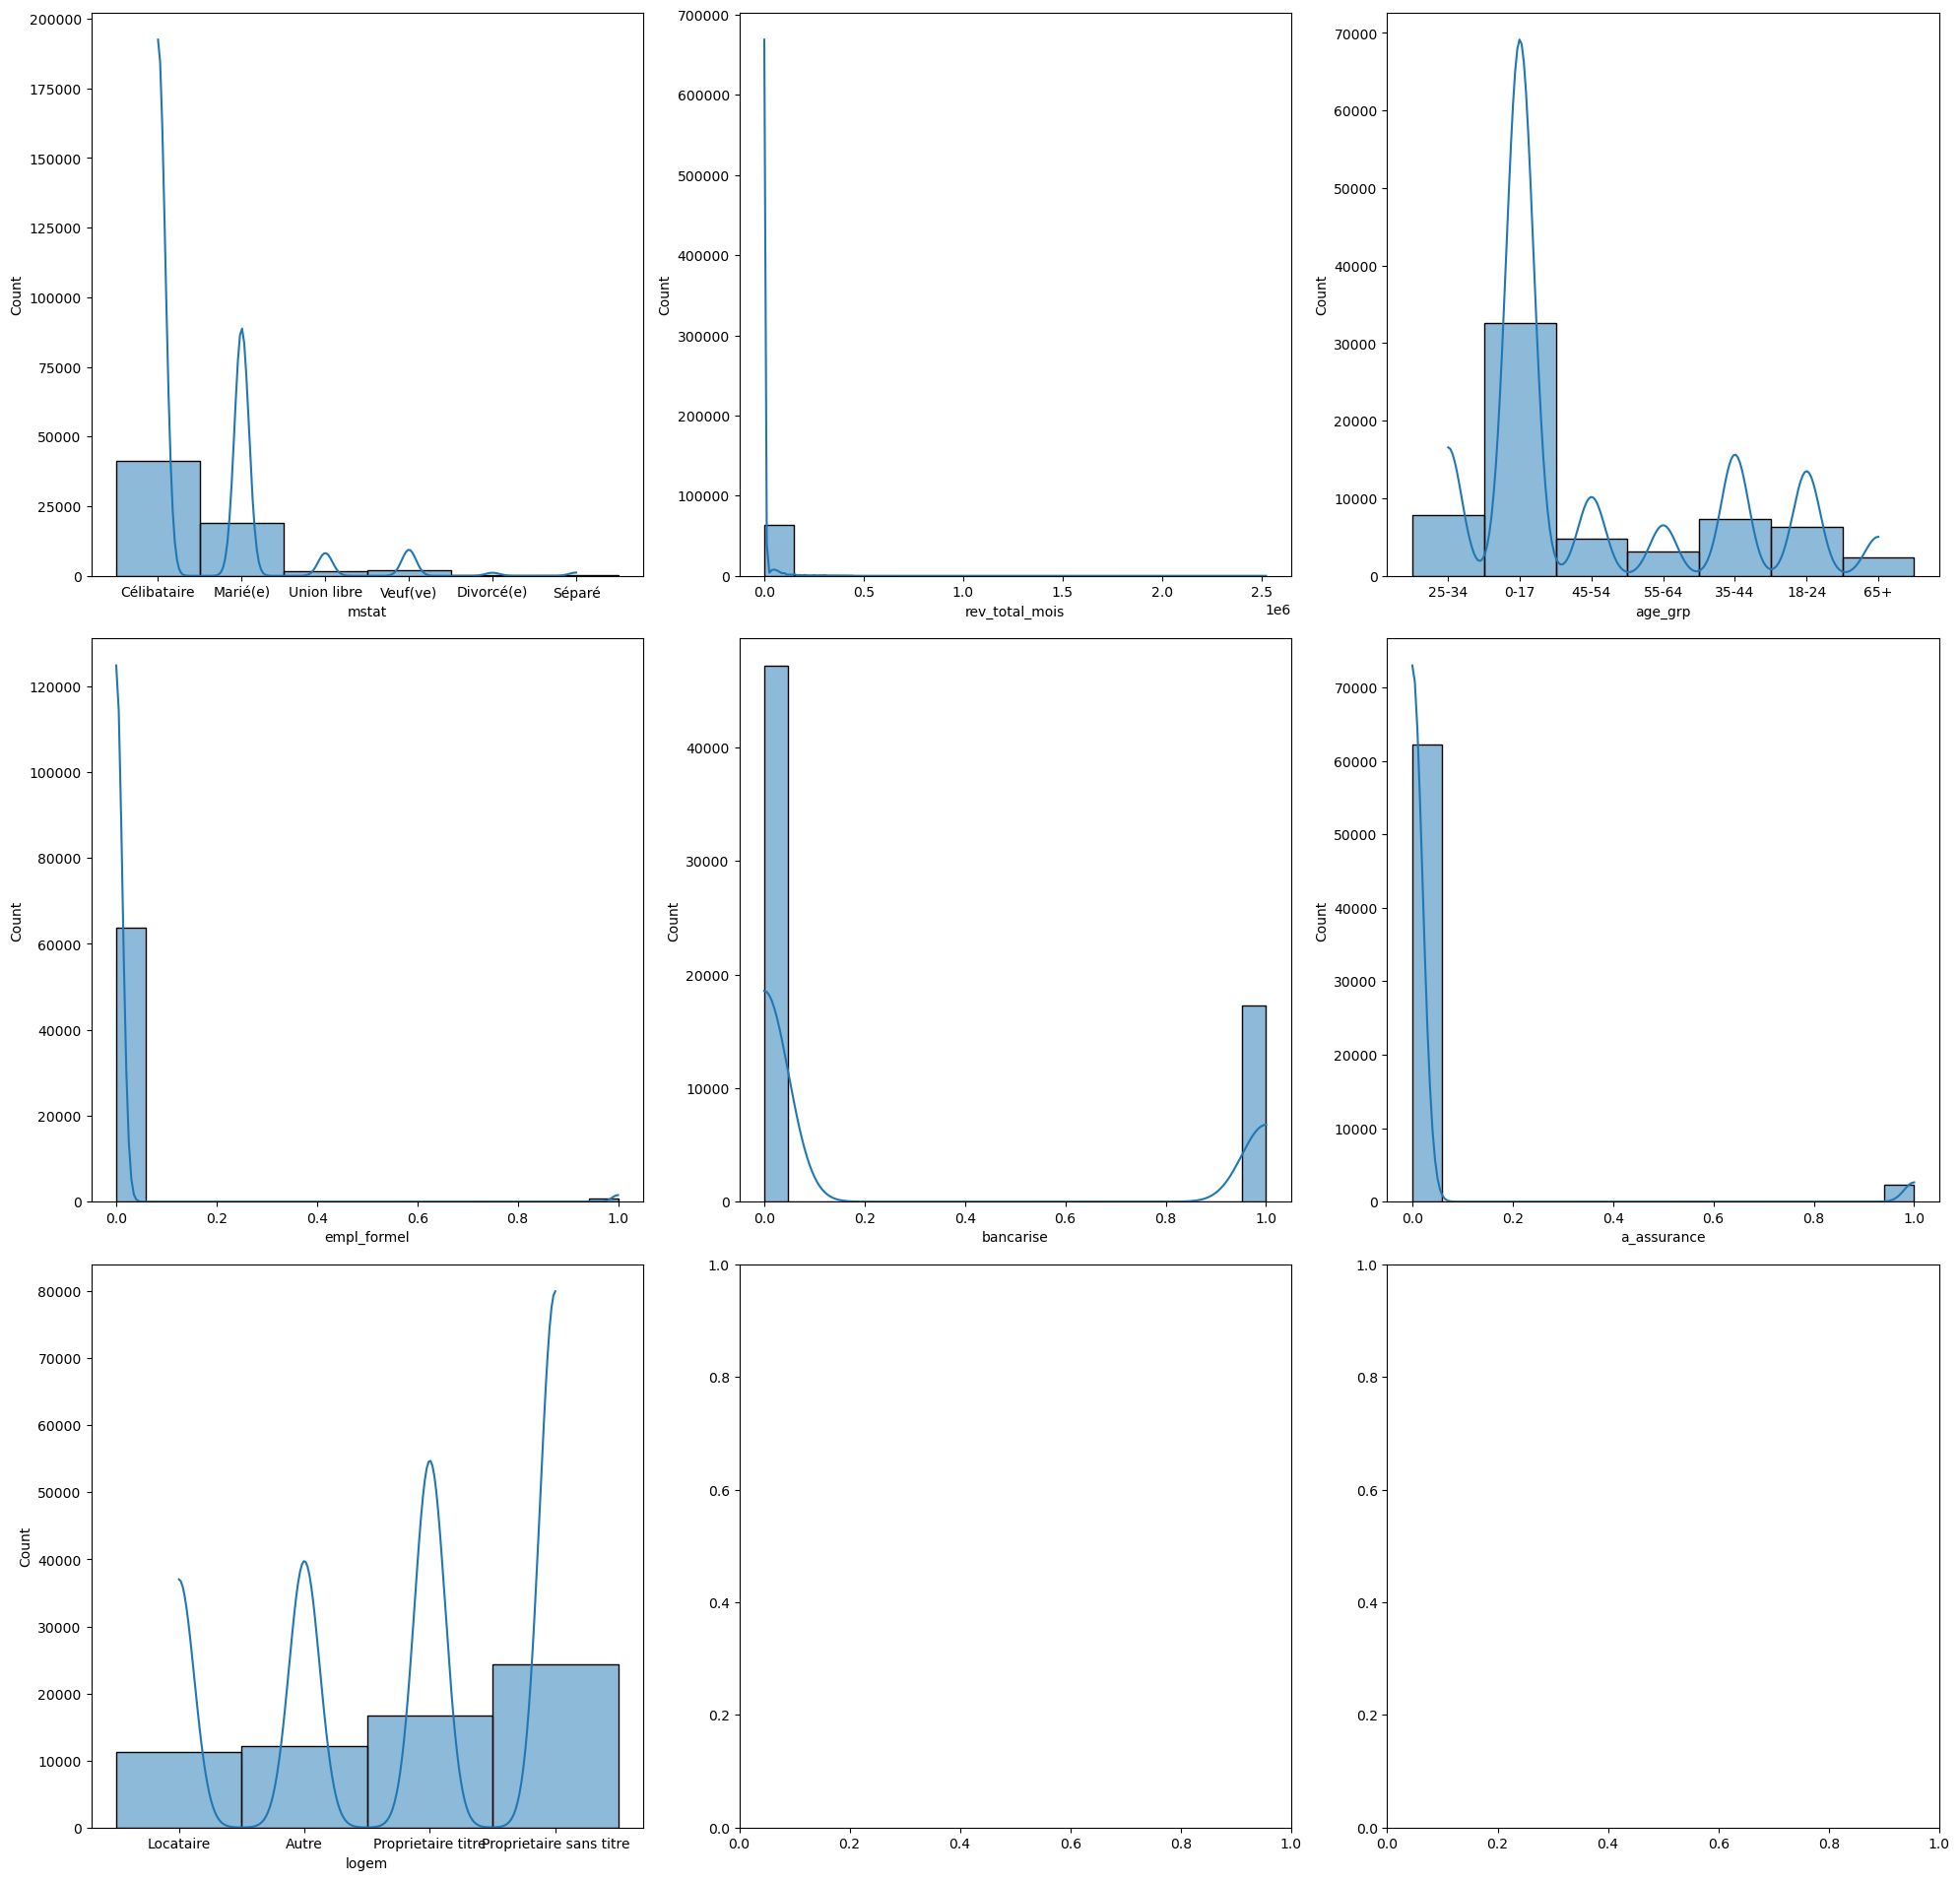

In [5]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
ax = ax.flatten()
i = 0
C_df_score.replace([np.inf, -np.inf], np.nan, inplace=True)
for col in C_df_score.columns:
    sns.histplot(data = C_df_score, x=col,kde = True ,ax = ax[i])
    i += 1
plt.tight_layout(rect=[0, 0, 1, 0.96])
print("Differentes catégories")
plt.show()

**INTEPRETATIONS DES GRAPHS :** 

**mstat (Situation matrimoniale)**

    La variable montre une majorité d'individus célibataires et mariés, avec beaucoup moins d'unions libres, veufs, divorcés ou séparés. La distribution est très déséquilibrée, reflétant probablement la structure habituelle de la population adulte dans l'échantillon.

**rev_total_mois (Revenu total mensuel)**

    La répartition du revenu est très asymétrique à droite : la plupart des individus ont des revenus faibles, avec une toute petite proportion ayant des revenus très élevés. Cela suggère une forte inégalité économique ou sociale dans la population analysée.

**age_grp (Groupe d'âge)**

    On observe une concentration importante dans certains groupes d'âge (“0-17”, “25-34”) et moins de personnes dans les classes plus âgées (“65+”). Cette distribution est typique d’une population jeune.

**empl_formel (Emploi formel)**

    La majorité des individus n'ont pas d'emploi formel (valeur proche de zéro majoritaire). Cela traduit une forte prévalence de l’informel dans l’emploi.

**bancarise (Bancarisation)**

    On distingue deux pics distincts (0 et 1) : une part significative de la population n’a pas accès à la bancarisation. Cela confirme une faible inclusion financière “officielle” dans l’échantillon.

**a_assurance (Accès à une assurance maladie)**

    La tendance est similaire à la bancarisation : très peu de personnes disposent d'une assurance. La couverture reste très marginale.

**logem (Statut logement)**

    La distribution est légèrement inégale, avec une préférence claire pour certains statuts (propriétaire sans titre et locataire dominant), ce qui reflète les situations courantes de logement.

**Profil_Score (Score d’inclusion financière)**

    La variable se concentre autour de certains scores typiques, avec des pics répétés : cela reflète la segmentation introduite par tes règles de scoring. On note une diversité mais une polarisation sur quelques profils dominants.

**OBSERVATION**
    
**Ces observations faites des tendances de la population ont un impact sur les critères du profil.**

## **CREATION OF THE TARGET**

In [6]:

def score_inclusion_financiere(row):
    score = 0
       
    #print(f"\n---------------------Data {row.name}------------------\n")

    # Situation Matrimoniale (20 points)
    if row['mstat'] in ["Marié(e)", "Union libre"]:
        score += 20
    elif row['mstat'] in ["Célibataire", "Divorcé(e)", "Séparé"]:
        score += 8
    elif row['mstat'] == "Veuf(ve)":
        score += 10
    
    #print(f"1 - {score}")
    
    # Groupe d'Âge (10 points)
    if row['age_grp'] in ["18-24", "65+"]:
        score += 5
    elif row['age_grp'] in ["35-44", "45-54"]:
        score += 10
    elif row['age_grp'] in ["25-34", "55-64"]:
        score += 7
    
    #print(f"2 - {score}")
    
    # Bancarisation (15 points)
    if row['bancarise'] == 1:
        score += 15
    elif row['bancarise'] == 0:
        score += 8

    #print(f"3 - {score}")
    
    # Assurance (5 points)
    if row['a_assurance'] == 1:
        score += 5
    elif row['a_assurance'] == 0:
        score += 2

    #print(f"4 - {score}")
    
    # Emploi formel (5 points)
    if row['empl_formel'] == 1:
        score += 5
    elif row['empl_formel'] == 0:
        score += 2

    #print(f"5 - {score}")

    # Logement (20 points)
    if row['logem'] in ["Proprietaire sans titre", "Proprietaire titre"]:
        score += 20
    elif row['logem'] == "Locataire":
        score += 10

    #print(f"6 - {score}")

    # Revenu (25 points)
    if (row['rev_total_mois'] >= 50000) and (row['rev_total_mois'] < 300000):
        score += 5
    elif (row['rev_total_mois'] >= 300000) and (row['rev_total_mois'] < 500000):
        score += 10
    elif (row['rev_total_mois'] >= 500000) and (row['rev_total_mois'] < 1000000):
        score += 20
    elif row['rev_total_mois'] >= 1000000:
        score += 25

    #print(f"7 - {score}")
    #print(f"\n---------------------------------------\n")

    return score


In [7]:
C_df_score['Profil_Score'] = C_df_score.apply(score_inclusion_financiere, axis=1)
print("-------------- FIN DE LA CREATION DU TARGET --------------")

-------------- FIN DE LA CREATION DU TARGET --------------


In [8]:
classes = C_df_score['Profil_Score'].unique()
classes

array([ 52,  30,  49,  59,  56,  42,  44,  47,  37,  33,  45,  75,  70,
        62,  20,  34,  27,  65,  35,  23,  25,  32,  60,  57,  50,  55,
        64,  54,  40,  71,  74,  39,  46,  61,  68,  69,  43,  66,  85,
        77,  67,  38,  72,  51,  36,  63,  82,  88,  92,  73,  87,  48,
        94,  95, 100,  80,  79,  89,  90,  83,  84,  53,  28,  58,  76,
        41,  29])

In [9]:
C_df_score['Profil_Score'].nunique()

67

In [10]:
C_df_score

,mstat,rev_total_mois,age_grp,empl_formel,bancarise,a_assurance,logem,Profil_Score
0,Célibataire,279244.0,25-34,1,1,0,Locataire,52
1,Célibataire,0.0,0-17,0,0,0,Locataire,30
2,Célibataire,0.0,0-17,0,0,0,Locataire,30
3,Célibataire,0.0,0-17,0,0,0,Locataire,30
4,Marié(e),0.0,25-34,0,0,0,Locataire,49
...,...,...,...,...,...,...,...,...
64469,Célibataire,0.0,0-17,0,0,0,Proprietaire titre,40
64470,Célibataire,0.0,0-17,0,0,0,Proprietaire titre,40
64471,Célibataire,0.0,0-17,0,0,0,Proprietaire titre,40
64472,Célibataire,0.0,0-17,0,0,0,Proprietaire titre,40


In [11]:
#C_df_score.to_csv("../DATAS/ProfilS_ML.csv", index=False, encoding="utf-8")

## **LABELING OF VARIABLES**

In [12]:
label_encoders = {}

# Variables catégorielles à encoder
cat_cols = ['mstat', 'age_grp', 'logem']

for col in cat_cols:
    le = LabelEncoder()
    C_df_score[col] = le.fit_transform(C_df_score[col])
    label_encoders[col] = le
C_df_score

,mstat,rev_total_mois,age_grp,empl_formel,bancarise,a_assurance,logem,Profil_Score
0,0,279244.0,2,1,1,0,1,52
1,0,0.0,0,0,0,0,1,30
2,0,0.0,0,0,0,0,1,30
3,0,0.0,0,0,0,0,1,30
4,2,0.0,2,0,0,0,1,49
...,...,...,...,...,...,...,...,...
64469,0,0.0,0,0,0,0,3,40
64470,0,0.0,0,0,0,0,3,40
64471,0,0.0,0,0,0,0,3,40
64472,0,0.0,0,0,0,0,3,40


In [13]:
#C_df_score.to_csv("../DATAS/Label_ProfilS_ML.csv", index=False, encoding="utf-8")

In [14]:
# Afficher les mappings pour chaque variable
for col in cat_cols:
    le = label_encoders[col]
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"Mapping '{col}':")
    for k, v in mapping.items():
        print(f"  {k} -> {v}")
    print("-" * 30)

Mapping 'mstat':
  Célibataire -> 0
  Divorcé(e) -> 1
  Marié(e) -> 2
  Séparé -> 3
  Union libre -> 4
  Veuf(ve) -> 5
------------------------------
Mapping 'age_grp':
  0-17 -> 0
  18-24 -> 1
  25-34 -> 2
  35-44 -> 3
  45-54 -> 4
  55-64 -> 5
  65+ -> 6
------------------------------
Mapping 'logem':
  Autre -> 0
  Locataire -> 1
  Proprietaire sans titre -> 2
  Proprietaire titre -> 3
------------------------------


In [15]:
C_df_score

,mstat,rev_total_mois,age_grp,empl_formel,bancarise,a_assurance,logem,Profil_Score
0,0,279244.0,2,1,1,0,1,52
1,0,0.0,0,0,0,0,1,30
2,0,0.0,0,0,0,0,1,30
3,0,0.0,0,0,0,0,1,30
4,2,0.0,2,0,0,0,1,49
...,...,...,...,...,...,...,...,...
64469,0,0.0,0,0,0,0,3,40
64470,0,0.0,0,0,0,0,3,40
64471,0,0.0,0,0,0,0,3,40
64472,0,0.0,0,0,0,0,3,40


### **Correlation Matrix**

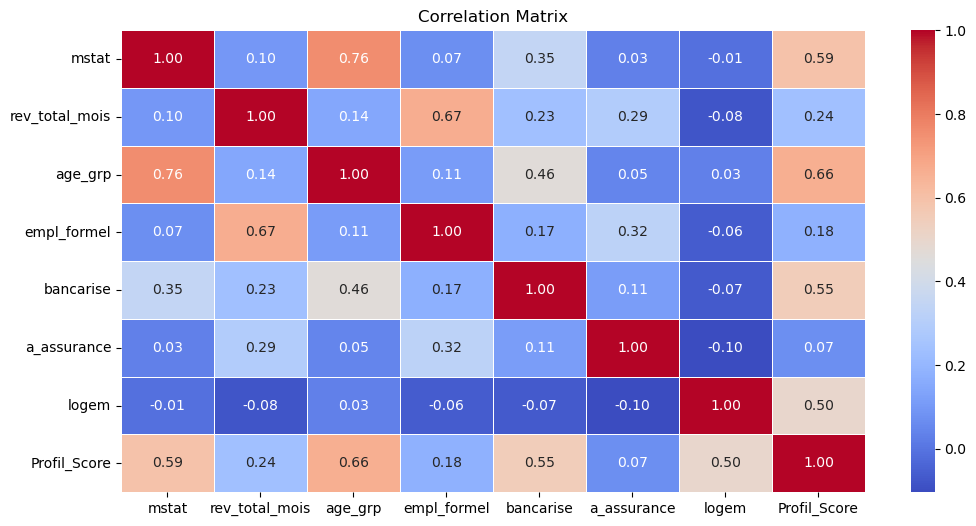

In [16]:
df_subset = C_df_score
corr_matrix = df_subset.corr()
plt.figure(figsize = (12,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

#### Les méthodes de filtrage comme la corrélation ou le seuil de variance sont excellentes quand nous avons beaucoup de caractéristiques et voulons supprimer rapidement celles qui ne sont pas pertinentes et voir le comportement des caractérisques par rapport à la variable cible. Cependant, si nous voulons maximiser les performances du modèle et avoir les ressources de calcul, nous pourrions vouloir explorer des méthodes d'emballage comme RFE ou des méthodes intégrées comme Lasso. 

#### La matrice de correlation permet aussi d'observer les variables qui sont corrélées entre elles et celles qui ont un impact sur la variable cible. Ainsi l'on à une idée de comment maximiser les performances du modèle et optimiser à l'avance les erreurs possibles du modèle.

#### OBSERVATION : Les variables ne sont pas corrélées entre elles et à la variable cible. Pas de problème à ce niveau. 

## **SEPARATE THE FEATURES FROM THE TARGET**

In [17]:
# Separation des caractérisques et de la cible

X = C_df_score.drop(columns=['Profil_Score'])
y = C_df_score['Profil_Score']

In [18]:
X

,mstat,rev_total_mois,age_grp,empl_formel,bancarise,a_assurance,logem
0,0,279244.0,2,1,1,0,1
1,0,0.0,0,0,0,0,1
2,0,0.0,0,0,0,0,1
3,0,0.0,0,0,0,0,1
4,2,0.0,2,0,0,0,1
...,...,...,...,...,...,...,...
64469,0,0.0,0,0,0,0,3
64470,0,0.0,0,0,0,0,3
64471,0,0.0,0,0,0,0,3
64472,0,0.0,0,0,0,0,3


In [19]:
y

0        52
1        30
2        30
3        30
4        49
         ..
64469    40
64470    40
64471    40
64472    40
64473    69
Name: Profil_Score, Length: 64474, dtype: int64

## **SEPARATION OF TRAINING AND TESTING**

In [20]:
features = ['mstat', 'age_grp', 'bancarise', 'a_assurance', 'empl_formel', 'logem', 'rev_total_mois']
target = 'Profil_Score'

In [21]:
# Données d'entrainement et de test

X_train_n, X_test_n, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train :{X_train_n.shape}")
print(f"y_train :{y_train.shape}")
print(f"X_test :{X_test_n.shape}")
print(f"y_test :{y_test.shape}")

X_train :(51579, 7)
y_train :(51579,)
X_test :(12895, 7)
y_test :(12895,)


In [22]:
X_train_n

,mstat,rev_total_mois,age_grp,empl_formel,bancarise,a_assurance,logem
63948,2,0.000,4,0,1,0,0
63290,1,0.000,4,0,1,0,0
18502,5,51173.582,5,0,0,0,0
5734,0,0.000,0,0,0,0,0
30553,0,0.000,0,0,0,0,3
...,...,...,...,...,...,...,...
62570,2,0.000,4,0,0,0,2
38158,2,0.000,2,0,0,0,3
860,0,0.000,0,0,1,0,3
15795,0,0.000,0,0,0,0,0


## **STANDARDIZATION OF VARIABLES**

In [23]:
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train_n)
#X_test = scaler.transform(X_test_n)


In [24]:
#X_train

In [25]:
#X_test

## **MODEL TRAINING PROCESS**

### **Choice The Best Model**

In [26]:
models = {
    "Random Regressor" : RandomForestRegressor(n_estimators=10, random_state=42, max_depth=10),
    "XGBRegressor" : XGBRegressor(n_estimators=100, learning_rate=0.13, random_state=42)
}

results = {}


🏆 Random Regressor
          - RMSE CV: 0.5444 ± 0.0258
          - R2 CV: 0.9984 ± 0.0001
          - R2 (test): 0.9984
          - RMSE (test): 0.5357



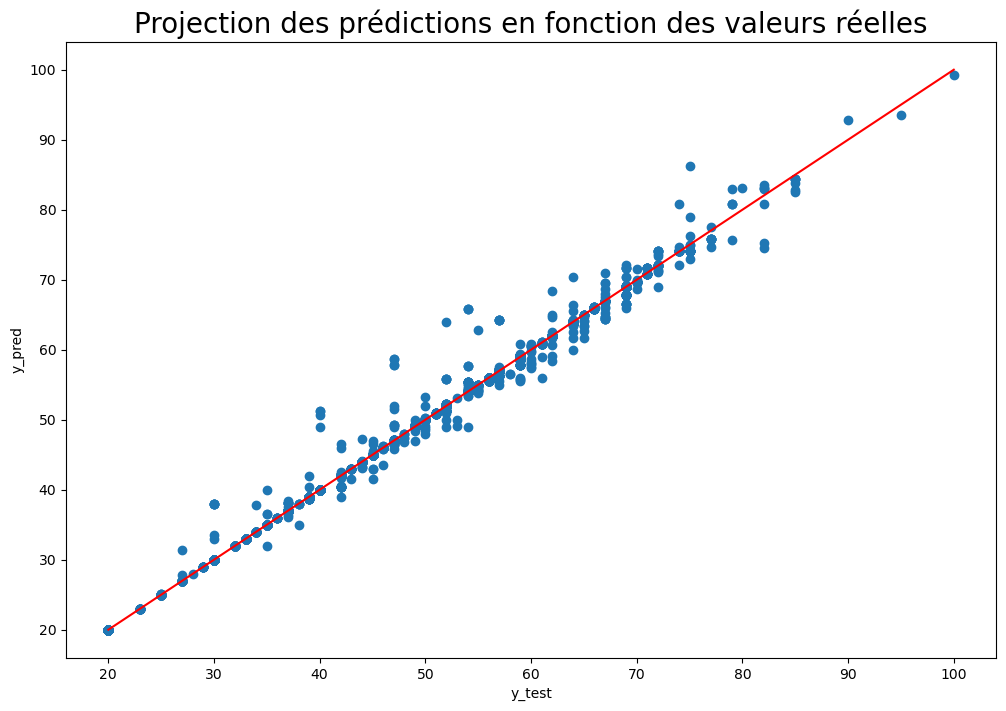

          Importance des variables :
          variable  importance
0           mstat    0.560854
6  rev_total_mois    0.309697
2       bancarise    0.062607
4     empl_formel    0.047025
1         age_grp    0.017391
5           logem    0.001505
3     a_assurance    0.000921


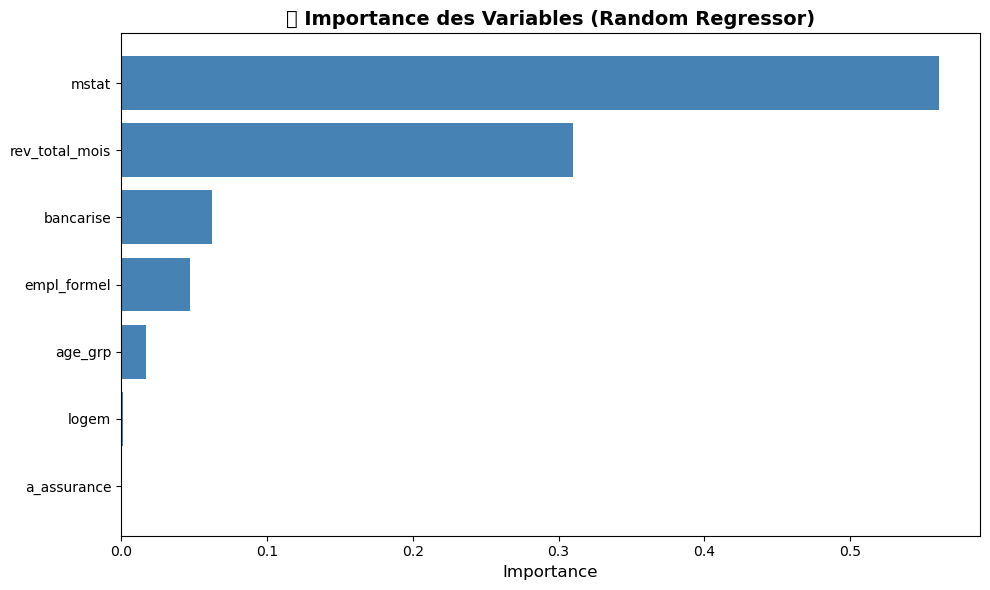


🏆 XGBRegressor
          - RMSE CV: 0.1780 ± 0.0245
          - R2 CV: 0.9998 ± 0.0000
          - R2 (test): 0.9999
          - RMSE (test): 0.1418



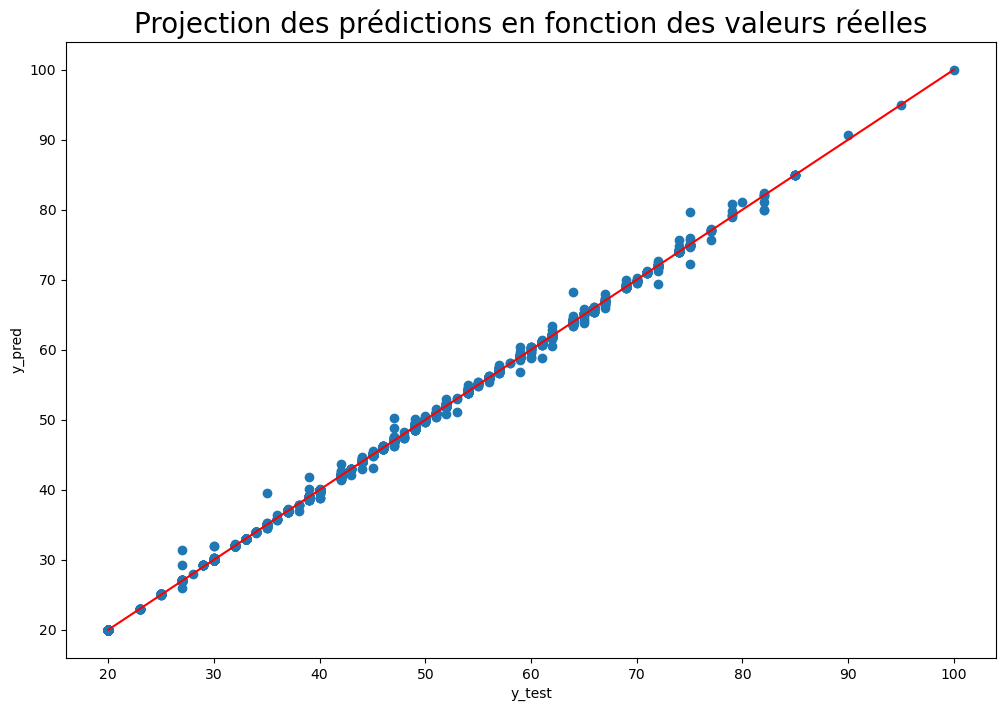

          Importance des variables :
          variable  importance
0           mstat    0.459693
6  rev_total_mois    0.351353
2       bancarise    0.088887
4     empl_formel    0.075186
3     a_assurance    0.010284
1         age_grp    0.009828
5           logem    0.004769


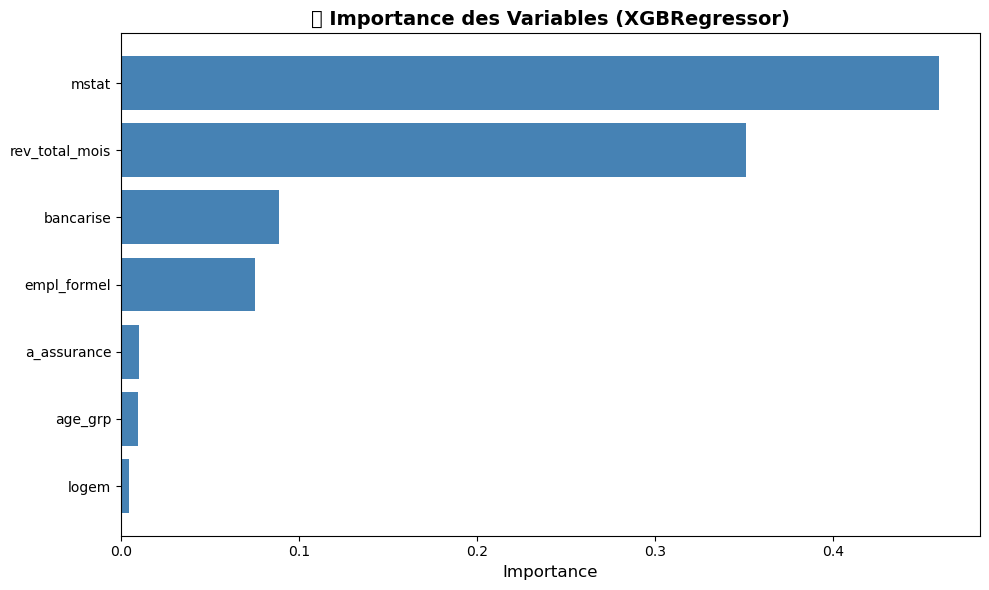

In [27]:
for name, model in models.items():
    # Validation croisée sur le train set
    rmse_scores = -cross_val_score(model, X_train_n, y_train, cv=5, scoring='neg_root_mean_squared_error')
    r2_scores = cross_val_score(model, X_train_n, y_train, cv=5, scoring='r2')
    print(f"\n🏆 {name}")
    print(f"          - RMSE CV: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
    print(f"          - R2 CV: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")

    # Fit sur tout le train set et prédiction sur test
    model.fit(X_train_n, y_train)
    y_pred = model.predict(X_test_n)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"          - R2 (test): {r2:.4f}")
    print(f"          - RMSE (test): {rmse:.4f}\n")
    joblib.dump(model, f'{name}.pkl')
    results[name] = {'rmse_cv': rmse_scores.mean(), 'r2_cv': r2_scores.mean(), 'rmse_test': rmse, 'r2_test': r2}

    # Predictions
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(y_test, y_pred)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='r')
    ax.set(xlabel='y_test', ylabel='y_pred')
    plt.title("Projection des prédictions en fonction des valeurs réelles", fontsize=20)
    plt.show()
        
    # Importance des variables
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        importance_df = pd.DataFrame({'variable': features, 'importance': importances}).sort_values(by='importance', ascending=False)
        print("          Importance des variables :\n", importance_df)
        plt.figure(figsize=(10, 6))
        plt.barh(importance_df['variable'], importance_df['importance'], color='steelblue')
        plt.xlabel('Importance', fontsize=12)
        plt.title(f'📊 Importance des Variables ({name})', fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

### **Vizualisation Models**

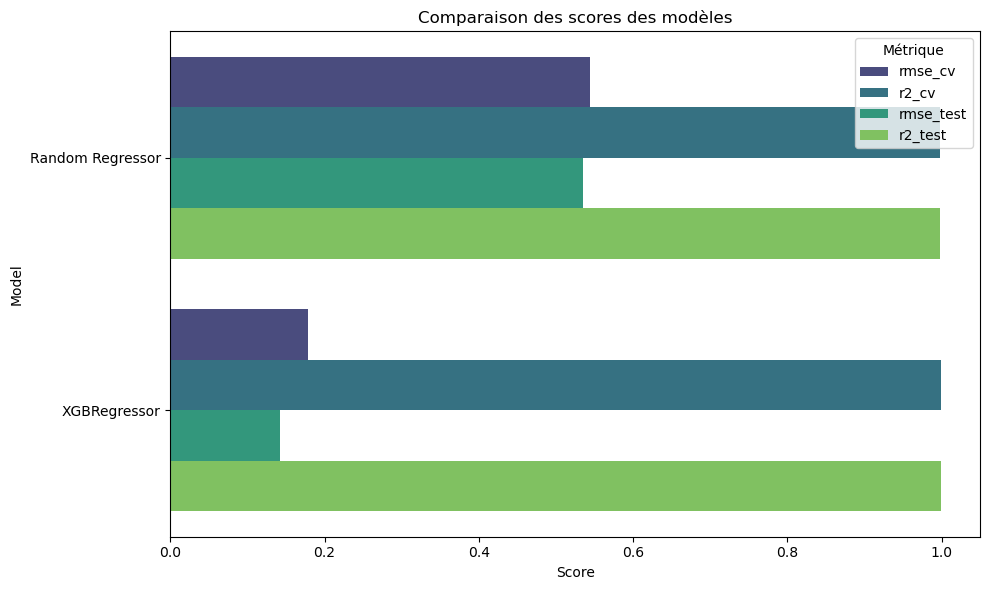

In [28]:
results_long = []
for model, scores in results.items():
    for metric, value in scores.items():
        results_long.append({'Model': model, 'Metric': metric, 'Score': value})

results_df = pd.DataFrame(results_long)

# Visualisation : un barplot par métrique
plt.figure(figsize=(10, 6))
sns.barplot(x="Score", y="Model", hue="Metric", data=results_df, palette="viridis")
plt.xlabel("Score")
plt.ylabel("Model")
plt.title("Comparaison des scores des modèles")
plt.legend(title="Métrique")
plt.tight_layout()
plt.show()

### **Search for the Hyperparameter of the Best Model**

### **Search for the Hyperparameter of Random Forest Regressor**

In [29]:
rf = RandomForestRegressor(random_state=42)

# Grille d'hyperparamètres
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

#### **GridSearchCV with RMSE**

In [30]:
# GridSearchCV avec RMSE comme métric
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,         # 5-fold cross validation
    scoring='neg_root_mean_squared_error', # RMSE
    n_jobs=-1,
    verbose=1
)

# Entraînement sur le train set
grid_search_rf.fit(X_train_n, y_train)

print("Meilleurs paramètres :", grid_search_rf.best_params_)
print("Meilleur score RMSE CV RF :", -grid_search_rf.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Meilleurs paramètres : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Meilleur score RMSE CV RF : 0.3490372742900608


#### **GridSearchCV with R2**

In [31]:
# GridSearchCV avec R2 comme métric
grid_search_r2 = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid_search_r2.fit(X_train_n, y_train)

print("Meilleurs paramètres :", grid_search_r2.best_params_)
print("Meilleur score R2 CV RF :", grid_search_r2.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Meilleurs paramètres : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Meilleur score R2 CV RF : 0.9993404422238784


### **Search for the Hyperparameter of XGBRegressor**

In [32]:
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

#### **GridSearchCV with RMSE**

In [33]:
grid_search_xgb = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid_xgb,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
grid_search_xgb.fit(X_train_n, y_train)
print("Meilleurs paramètres XGB :", grid_search_xgb.best_params_)
print("Meilleur score RMSE CV XGB :", -grid_search_xgb.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Meilleurs paramètres XGB : {'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Meilleur score RMSE CV XGB : 0.09121320247650147


#### **GridSearchCV with R2**

In [34]:
grid_search_xr2 = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid_xgb,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid_search_xr2.fit(X_train_n, y_train)
print("Meilleurs paramètres XGB :", grid_search_xr2.best_params_)
print("Meilleur score R2 CV XGB :", grid_search_xr2.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Meilleurs paramètres XGB : {'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Meilleur score R2 CV XGB : 0.9999552965164185


#### **Principes de recherches des hypers paramètres**

**estimator=rf**

        Modèle de base que tu souhaites entraîner et optimiser, ici un Random Forest Regressor
**param_grid=param_grid**

    Un dictionnaire contenant les hyperparamètres et leurs différentes valeurs possibles.
    GridSearchCV essaiera toutes les combinaisons possibles listées pour trouver la meilleure
**cv=5**

    Le nombre de folds dans la validation croisée.Ici, le dataset est divisé en 5 parties différentes.
    4 parts servent à l'entraînement, 1 à la validation, et ce, 5 fois en changeant la partie de validation.
**scoring='neg_root_mean_squared_error'**

    RMSE : La métrique utilisée pour évaluer la performance du modèle
    
**scoring='r2'**
    
    r2 : La métrique utilisée pour évaluer la performance du modèle
**n_jobs=-1**
    
    Utilisation de tous les cœurs CPU disponibles pour paralléliser le calcul
**verbose**
    
    Contrôle le niveau de verbosité (affichage d'informations pendant l'exécution) 
    0 = Aucunes infos
    1 = Moins détaillés
    2 = Infos détaillés

### **Retraining the model with the hyperparameter**

In [35]:
# Évaluation sur le test set avec meilleur modèle
best_params_rf = grid_search_rf.best_params_
best_params_xgb = grid_search_xgb.best_params_

#### **Retraining model**

In [36]:
# RandomForestRegressor
best_rf = RandomForestRegressor(**best_params_rf, random_state=2)
best_rf.fit(X_train_n, y_train)

# XGBRegressor
best_xgb = XGBRegressor(**best_params_xgb, random_state=2)
best_xgb.fit(X_train_n, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.3, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

          Importance des variables :
          variable  importance
2       bancarise    0.487148
6  rev_total_mois    0.295147
0           mstat    0.144585
4     empl_formel    0.058288
5           logem    0.006819
1         age_grp    0.005865
3     a_assurance    0.002149


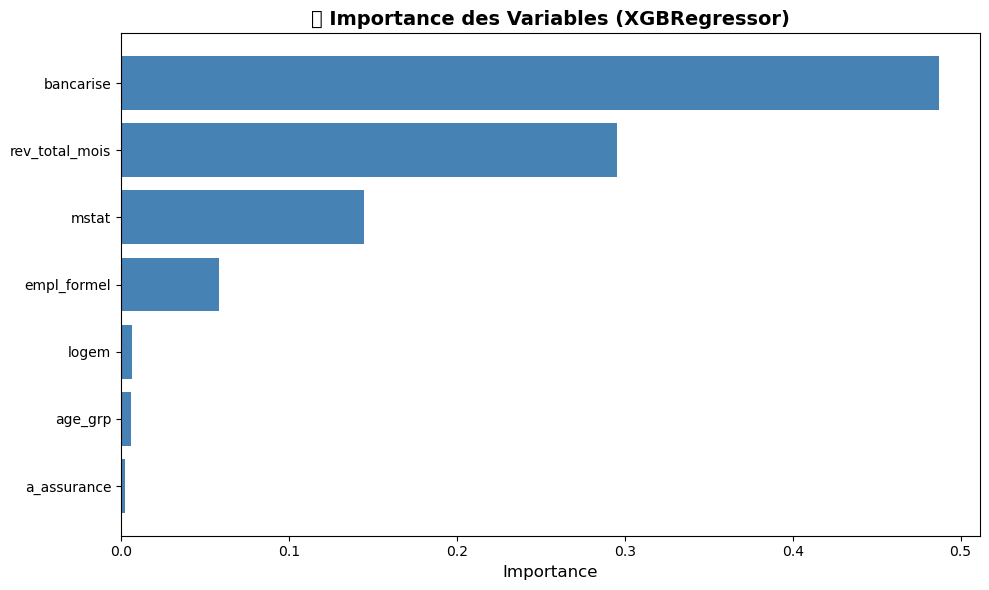

In [37]:

if hasattr(best_xgb, "feature_importances_"):
        importances = best_xgb.feature_importances_
        import_df = pd.DataFrame({'variable': features, 'importance': importances}).sort_values(by='importance', ascending=False)
        print("          Importance des variables :\n", import_df)
        plt.figure(figsize=(10, 6))
        plt.barh(import_df['variable'], import_df['importance'], color='steelblue')
        plt.xlabel('Importance', fontsize=12)
        plt.title(f'📊 Importance des Variables ({name})', fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

### **Evaluation with set test**

In [38]:
# Prédictions
y_pred_rf = best_rf.predict(X_test_n)
y_pred_xgb = best_xgb.predict(X_test_n)

# Scores
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"RandomForestRegressor - RMSE: {rmse_rf:.4f}, R2: {r2_rf:.4f}")
print(f"XGBRegressor - RMSE: {rmse_xgb:.4f}, R2: {r2_xgb:.4f}")

RandomForestRegressor - RMSE: 0.2657, R2: 0.9996
XGBRegressor - RMSE: 0.1215, R2: 0.9999


### **Use the loaded model to make predictions**

In [39]:
joblib.dump(best_rf, "best_rf.pkl")
joblib.dump(best_xgb, "best_xgb.pkl")

['best_xgb.pkl']

In [40]:
#model_load_rf = joblib.load('Random Regressor.pkl')
#model_load_xgb = joblib.load('XGBRegressor.pkl')

In [41]:
model_load_rf = joblib.load('best_rf.pkl')
model_load_xgb = joblib.load('best_xgb.pkl')

In [42]:
dat = pd.DataFrame([{'mstat':0, 'rev_total_mois':279244.0, 'age_grp':2, 'empl_formel':1, 'bancarise':1, 'a_assurance':0, 'logem':1},
                    {'mstat':0, 'rev_total_mois':380000.00,   'age_grp':3, 'empl_formel':1, 'bancarise':1, 'a_assurance':1, 'logem':1},
                    {'mstat':2, 'rev_total_mois':0.00,    'age_grp':2, 'empl_formel':0, 'bancarise':1, 'a_assurance':0, 'logem':1},
                    {'mstat':2, 'rev_total_mois':200000.00,   'age_grp':3, 'empl_formel':1, 'bancarise':1, 'a_assurance':1, 'logem':1},
                    {'mstat':0, 'rev_total_mois':0.00,    'age_grp':0, 'empl_formel':0, 'bancarise':0, 'a_assurance':1, 'logem':1},
                    {'mstat':2, 'rev_total_mois':0.00,   'age_grp':4, 'empl_formel':0, 'bancarise':1, 'a_assurance':1, 'logem':1},
                    {'mstat':2, 'rev_total_mois':316733.34,   'age_grp':4, 'empl_formel':1, 'bancarise':1, 'a_assurance':1, 'logem':1}
    ])
dat

#  75,  44,  70,  33,  62,  75
#'Profil_Score':85, 'Profil_Score':62, 'Profil_Score':91, 'Profil_Score':33

,mstat,rev_total_mois,age_grp,empl_formel,bancarise,a_assurance,logem
0,0,279244.00,2,1,1,0,1
1,0,380000.00,3,1,1,1,1
2,2,0.00,2,0,1,0,1
3,2,200000.00,3,1,1,1,1
4,0,0.00,0,0,0,1,1
5,2,0.00,4,0,1,1,1
6,2,316733.34,4,1,1,1,1


In [43]:
#scale = StandardScaler()
#scal = scale.fit_transform(dat)
#scal

In [44]:
pre_rf = model_load_xgb.predict(dat)
pre_rf

array([51.903446, 63.285976, 56.03504 , 69.9375  , 32.999763, 61.95502 ,
       74.913216], dtype=float32)

In [45]:
# Test intérieur du modèle extrait
datas = pd.DataFrame([
    {'mstat':0, 'rev_total_mois':0,        'age_grp':0, 'empl_formel':0, 'bancarise':0, 'a_assurance':0, 'logem':1, 'Profil_Score':28},
    {'mstat':1, 'rev_total_mois':50000,    'age_grp':1, 'empl_formel':1, 'bancarise':1, 'a_assurance':1, 'logem':2, 'Profil_Score':65},
    {'mstat':2, 'rev_total_mois':120000,   'age_grp':2, 'empl_formel':0, 'bancarise':1, 'a_assurance':0, 'logem':3, 'Profil_Score':78},
    {'mstat':3, 'rev_total_mois':250000,   'age_grp':3, 'empl_formel':1, 'bancarise':0, 'a_assurance':1, 'logem':0, 'Profil_Score':49},
    {'mstat':4, 'rev_total_mois':400000,   'age_grp':4, 'empl_formel':0, 'bancarise':1, 'a_assurance':1, 'logem':2, 'Profil_Score':85},
    {'mstat':5, 'rev_total_mois':30000,    'age_grp':5, 'empl_formel':1, 'bancarise':0, 'a_assurance':1, 'logem':3, 'Profil_Score':62},
    {'mstat':2, 'rev_total_mois':900000,   'age_grp':6, 'empl_formel':0, 'bancarise':1, 'a_assurance':0, 'logem':2, 'Profil_Score':91},
    {'mstat':0, 'rev_total_mois':150000,   'age_grp':1, 'empl_formel':0, 'bancarise':0, 'a_assurance':0, 'logem':0, 'Profil_Score':33},
    {'mstat':4, 'rev_total_mois':80000,    'age_grp':5, 'empl_formel':1, 'bancarise':1, 'a_assurance':1, 'logem':1, 'Profil_Score':72},
    {'mstat':1, 'rev_total_mois':1000000,  'age_grp':0, 'empl_formel':0, 'bancarise':0, 'a_assurance':0, 'logem':2, 'Profil_Score':38},
    {'mstat':5, 'rev_total_mois':290000,   'age_grp':3, 'empl_formel':1, 'bancarise':1, 'a_assurance':0, 'logem':3, 'Profil_Score':70},
    {'mstat':1, 'rev_total_mois':750000,   'age_grp':4, 'empl_formel':1, 'bancarise':1, 'a_assurance':1, 'logem':0, 'Profil_Score':82},
    {'mstat':2, 'rev_total_mois':330000,   'age_grp':2, 'empl_formel':0, 'bancarise':0, 'a_assurance':1, 'logem':2, 'Profil_Score':55},
    {'mstat':0, 'rev_total_mois':200000,   'age_grp':1, 'empl_formel':1, 'bancarise':0, 'a_assurance':1, 'logem':1, 'Profil_Score':60},
    {'mstat':5, 'rev_total_mois':50000,    'age_grp':6, 'empl_formel':1, 'bancarise':0, 'a_assurance':0, 'logem':3, 'Profil_Score':41},
    {'mstat':4, 'rev_total_mois':870000,   'age_grp':0, 'empl_formel':0, 'bancarise':1, 'a_assurance':1, 'logem':1, 'Profil_Score':78},
    {'mstat':3, 'rev_total_mois':20000,    'age_grp':1, 'empl_formel':1, 'bancarise':1, 'a_assurance':0, 'logem':0, 'Profil_Score':44},
    {'mstat':2, 'rev_total_mois':450000,   'age_grp':3, 'empl_formel':0, 'bancarise':1, 'a_assurance':1, 'logem':3, 'Profil_Score':80},
    {'mstat':0, 'rev_total_mois':35000,    'age_grp':5, 'empl_formel':1, 'bancarise':0, 'a_assurance':0, 'logem':2, 'Profil_Score':39},
    {'mstat':5, 'rev_total_mois':800000,   'age_grp':6, 'empl_formel':1, 'bancarise':1, 'a_assurance':1, 'logem':2, 'Profil_Score':95}
])
datas

,mstat,rev_total_mois,age_grp,empl_formel,bancarise,a_assurance,logem,Profil_Score
0,0,0,0,0,0,0,1,28
1,1,50000,1,1,1,1,2,65
2,2,120000,2,0,1,0,3,78
3,3,250000,3,1,0,1,0,49
4,4,400000,4,0,1,1,2,85
5,5,30000,5,1,0,1,3,62
6,2,900000,6,0,1,0,2,91
7,0,150000,1,0,0,0,0,33
8,4,80000,5,1,1,1,1,72
9,1,1000000,0,0,0,0,2,38


In [46]:
datas_p = datas.drop(columns=['Profil_Score'])
y_datas = datas['Profil_Score']
y_datas

0     28
1     65
2     78
3     49
4     85
5     62
6     91
7     33
8     72
9     38
10    70
11    82
12    55
13    60
14    41
15    78
16    44
17    80
18    39
19    95
Name: Profil_Score, dtype: int64

In [47]:
datas_p

,mstat,rev_total_mois,age_grp,empl_formel,bancarise,a_assurance,logem
0,0,0,0,0,0,0,1
1,1,50000,1,1,1,1,2
2,2,120000,2,0,1,0,3
3,3,250000,3,1,0,1,0
4,4,400000,4,0,1,1,2
5,5,30000,5,1,0,1,3
6,2,900000,6,0,1,0,2
7,0,150000,1,0,0,0,0
8,4,80000,5,1,1,1,1
9,1,1000000,0,0,0,0,2


In [48]:
#scalers = StandardScaler()
#X_scal = scalers.fit_transform(datas_p)
#X_scal

#### **Random Regressor**

In [49]:
# Test de prédiction
#prediction_rf = model_load_rf.predict(X_test_n)
#prediction_rf

In [50]:
#rmse_rf_l = np.sqrt(mean_squared_error(y_test, prediction_rf))
#r2_rf_l = r2_score(y_test, prediction_rf)

#print(f"RMSE modèle load : {rmse_rf_l:.4f}")
#print(f"R2 modèle load : {r2_rf_l:.4f}")

In [51]:
pred_rf = model_load_rf.predict(datas_p)
pred_rf

array([30.   , 60.525, 71.   , 43.25 , 81.205, 49.   , 92.565, 30.   ,
       67.32 , 45.27 , 59.435, 56.215, 64.   , 42.115, 47.   , 74.505,
       36.32 , 81.29 , 47.   , 61.955])

In [52]:
rmse_rf_T = np.sqrt(mean_squared_error(y_datas, pred_rf))
r2_rf_T = r2_score(y_datas, pred_rf)

print(f"RMSE sur test : {rmse_rf_T:.4f}")
print(f"R2 sur test : {r2_rf_T:.4f}")

RMSE sur test : 11.8699
R2 sur test : 0.6458


#### **XGBRegressor**

In [53]:
# Test de prédiction
#prediction_xgb = model_load_xgb.predict(X_test_n)
#prediction_xgb

In [54]:
#rmse_xgb_l = np.sqrt(mean_squared_error(y_test, prediction_xgb))
#r2_xgb_l = r2_score(y_test, prediction_xgb)

#print(f"RMSE modèle load : {rmse_xgb_l:.4f}")
#print(f"R2 modèle load : {r2_xgb_l:.4f}")

In [55]:
pred_xgb = model_load_xgb.predict(datas_p)
pred_xgb

array([29.999596, 61.30151 , 70.869095, 39.16304 , 81.94302 , 53.19626 ,
       86.48184 , 29.548891, 66.804695, 50.96809 , 70.09609 , 64.487976,
       69.474144, 47.372135, 53.56708 , 63.69878 , 31.734837, 82.42341 ,
       49.441456, 78.55287 ], dtype=float32)

In [56]:
rmse_xgb_T = np.sqrt(mean_squared_error(y_datas, pred_xgb))
r2_xgb_T = r2_score(y_datas, pred_xgb)

print(f"RMSE sur test : {rmse_xgb_T:.4f}")
print(f"R2 sur test : {r2_xgb_T:.4f}")

RMSE sur test : 10.1330
R2 sur test : 0.7419


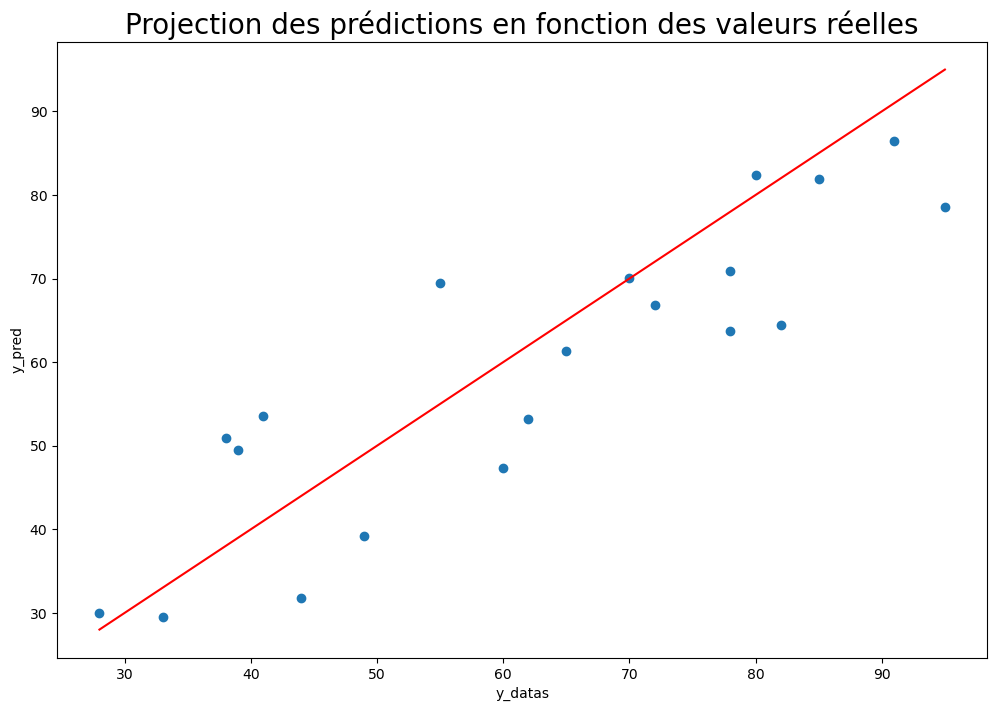

In [57]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(y_datas, pred_xgb)
ax.plot([y_datas.min(), y_datas.max()], [y_datas.min(), y_datas.max()], color='r')
ax.set(xlabel='y_datas', ylabel='y_pred')
plt.title("Projection des prédictions en fonction des valeurs réelles", fontsize=20)
plt.show()

### **RESUME**

Le modèle fait moins d'erreur avec les callibrages du meilleur hyper paramètre : 
    
    Erreur quadratique RMSE = 30% et un score R2 = 99.95%. 

Les performances sont élévés donc -. Conclusion le modèle Random Forest Regressor est retenu pour la mise en production et la suite du scoring.

## **MODEL DEPLOYMENT: EXTRACTION**

In [58]:
#joblib.dump(best_rf, "best_rf.pkl")
#joblib.dump(best_xgb, "best_xgb.pkl")

Exception ignored in: <function ResourceTracker.__del__ at 0x72da59391c60>
Traceback (most recent call last):
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x772d32595c60>
Traceback (most recent call last):
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7